## Final Project

In [1]:
library(tidyverse)
library(tidymodels)
library(repr) 
install.packages("kknn")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# Set the seed for reproducibility
set.seed(7)

# Importing the data, filling in the column names
process_data_cleveland <- read_delim("https://raw.githubusercontent.com/stephenDSCI/Heart-Disease-/main/processed.cleveland.data",
                                     col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"))

                                         

# Converting missing values that are ? into "NA"
process_data_cleveland[process_data_cleveland == "?" ] <- NA


# Changing the data type, renaming Sex as Male or Female, Renaming CP (chest pain type) into 4 types 1="Typical Angina", 2="Atypical Angina, 3="Atypical chest pain", 4= "Asymtomatic")

cleveland_data_1 <- process_data_cleveland |>
                    mutate(sex = as.factor(sex),
                           cp = as.factor(cp),
                           fbs = as.factor(fbs),
                           restecg = as.factor(restecg),
                           exang = as.factor(exang),
                           thal = as.factor(thal),
                           ca = as.factor(ca),
                           slope = as.factor(slope)) |>
                    mutate(sex = fct_recode(sex,"Male" = "1", "Female" = "0")) |>
                    mutate(cp = fct_recode(cp,"Typical Angina" = "1", "Atypical Angina" = "2","Non-Anginal Pain" = "3","Asymptomatic" = "4"))
                 


# Making a new column called diagnosis (If the corresponding value in the "num" column is NA, the value in the "diagnosis" column will be NA.
# If the value in the "num" column is greater than 0, the value in the "diagnosis" column will be TRUE; otherwise, it will be FALSE.)
# Makes the classification into two categories


cleveland_data_renamed <- cleveland_data_1 |>
    mutate(diagnosis=ifelse(is.na(num),NA,(num > 0)))|>
    mutate(diagnosis=as.factor(diagnosis))|>
    select(-num)

#Preview of data
head(cleveland_data_renamed)
     

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,Male,Typical Angina,145,233,1,2,150,0,2.3,3,0.0,6.0,FALSE
67,Male,Asymptomatic,160,286,0,2,108,1,1.5,2,3.0,3.0,TRUE
67,Male,Asymptomatic,120,229,0,2,129,1,2.6,2,2.0,7.0,TRUE
37,Male,Non-Anginal Pain,130,250,0,0,187,0,3.5,3,0.0,3.0,FALSE
41,Female,Atypical Angina,130,204,0,2,172,0,1.4,1,0.0,3.0,FALSE
56,Male,Atypical Angina,120,236,0,0,178,0,0.8,1,0.0,3.0,FALSE


#### Splitting data for training and testing

In [3]:
cleveland_split <- initial_split(cleveland_data_renamed, prop = 0.75, strata = diagnosis)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)
     

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,Male,Typical Angina,145,233,1,2,150,0,2.3,3,0.0,6.0,FALSE
41,Female,Atypical Angina,130,204,0,2,172,0,1.4,1,0.0,3.0,FALSE
57,Female,Asymptomatic,120,354,0,0,163,1,0.6,1,0.0,3.0,FALSE
57,Male,Asymptomatic,140,192,0,0,148,0,0.4,2,0.0,6.0,FALSE
44,Male,Atypical Angina,120,263,0,0,173,0,0.0,1,0.0,7.0,FALSE
52,Male,Non-Anginal Pain,172,199,1,0,162,0,0.5,1,0.0,7.0,FALSE


### Summarizing data

In [4]:
cleveland_summary <- cleveland_training |>
                    group_by(diagnosis) |>
                    summarize(
                              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),  
                              min_trestbps = min(trestbps), max_trestbps = max(trestbps), mean_trestbps = mean(trestbps),
                                min_age = min(age), max_age = max(age), mean_age = mean(age), 
                        
                        n_of_patients = n())

cleveland_summary

diagnosis,min_chol,max_chol,mean_chol,min_trestbps,max_trestbps,mean_trestbps,min_age,max_age,mean_age,n_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,126,394,239.4146,94,178,128.9756,29,76,51.78862,123
TRUE,131,409,249.6635,100,200,134.1346,35,70,56.78846,104


From the data, we can see that patients that have been diagnosed with heart disease tend to have a higher mean cholesterol and higher mean resting blood pressure. Therefore, let's explore these classifiers for predicting diagnoses. 

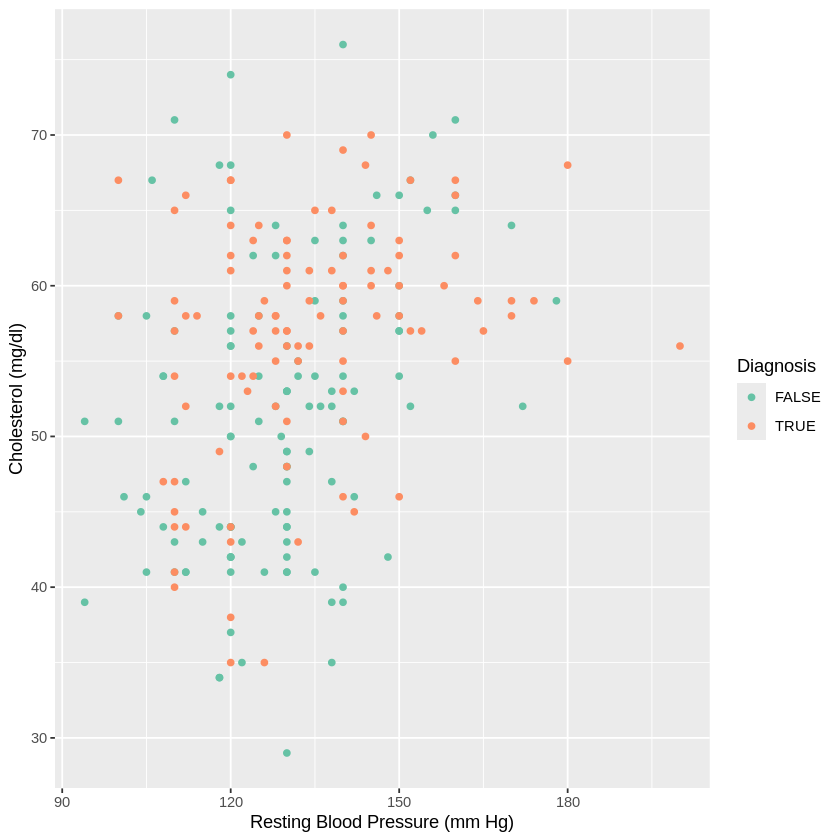

In [5]:
#OUR GROUPS CODE
cholesterol_blood_pressure_plot <- ggplot(cleveland_training, aes(x = trestbps, y = age, color = diagnosis)) +
                 geom_point() +
                 labs(x = "Resting Blood Pressure (mm Hg)", y = "Cholesterol (mg/dl)", color = "Diagnosis") +
                 scale_color_brewer(palette = "Set2")

cholesterol_blood_pressure_plot

This graph highlights the relationship between cholesterol levels and resting blood pressure. It seems that patients with heart disease (green) tend to have higher resting blood pressure and higher cholesterol whilepatients without heart disease (orange) have lower cholesterol and lower resting blood pressure.

### Finding the best k value

In [16]:
#Recipe
rbp_knn_recipe <- recipe(diagnosis ~ chol + trestbps, data = cleveland_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

#Model specification
rbp_knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#Perform 15 fold-cross validation 
rbp_knn_vfold <- vfold_cv(cleveland_training, v = 10, strata = diagnosis)

rbp_grid_vals <- tibble(neighbors = c(1:100)) 

#Workflow
rbp_knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = rbp_knn_vfold, grid = rbp_grid_vals) |>
    collect_metrics()


#Collecting metrics, filtering for accuracy
rbp_accuracies <- rbp_knn_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))

head(rbp_accuracies)


neighbors,mean
<int>,<dbl>
89,0.5589921
90,0.5589921
73,0.5544466
74,0.5544466
71,0.5542655
72,0.5542655


The best k values are shown in the table above but they only give us 56% accuracy. Therefore, my team would like to look at a different relationship other than resting blood pressure and cholesterol levels.

## Exploring new relationships!

In [21]:
further_analysis_summary <- cleveland_training |> 
    group_by(diagnosis) |>
    summarize(min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),
                              min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach), n_of_patients = n())

further_analysis_summary

diagnosis,min_chol,max_chol,mean_chol,min_thalach,max_thalach,mean_thalach,n_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,126,394,239.4146,105,202,160.4634,123
TRUE,131,409,249.6635,71,182,137.5192,104


We see that patients with heart disease tend to have higher cholesterl levels and lower maximum heart rates, let's explore this relationship!

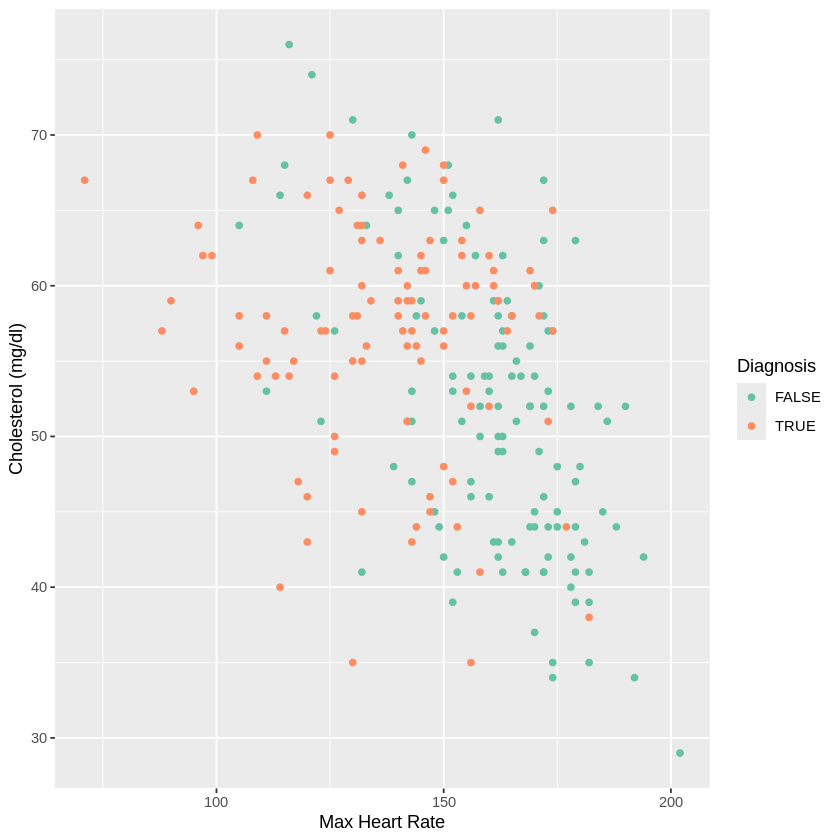

In [15]:
cholesterol_thalach_plot <- ggplot(cleveland_training, aes(x = thalach, y = age, color = diagnosis)) +
                 geom_point() +
                 labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", color = "Diagnosis") +
                 scale_color_brewer(palette = "Set2")

cholesterol_thalach_plot

In [17]:
#Recipe
knn_recipe <- recipe(diagnosis ~ chol + thalach, data = cleveland_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

#Model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#Perform 15 fold-cross validation 
knn_vfold <- vfold_cv(cleveland_training, v = 10, strata = diagnosis)

grid_vals <- tibble(neighbors = c(1:100)) 

#Workflow
knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = grid_vals) |>
    collect_metrics()


#Collecting metrics, filtering for accuracy
accuracies <- knn_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))

head(accuracies)


neighbors,mean
<int>,<dbl>
19,0.7458827
20,0.7458827
21,0.7415184
22,0.7415184
13,0.7407609
14,0.7407609


### Visualizing the accuracy of our k value

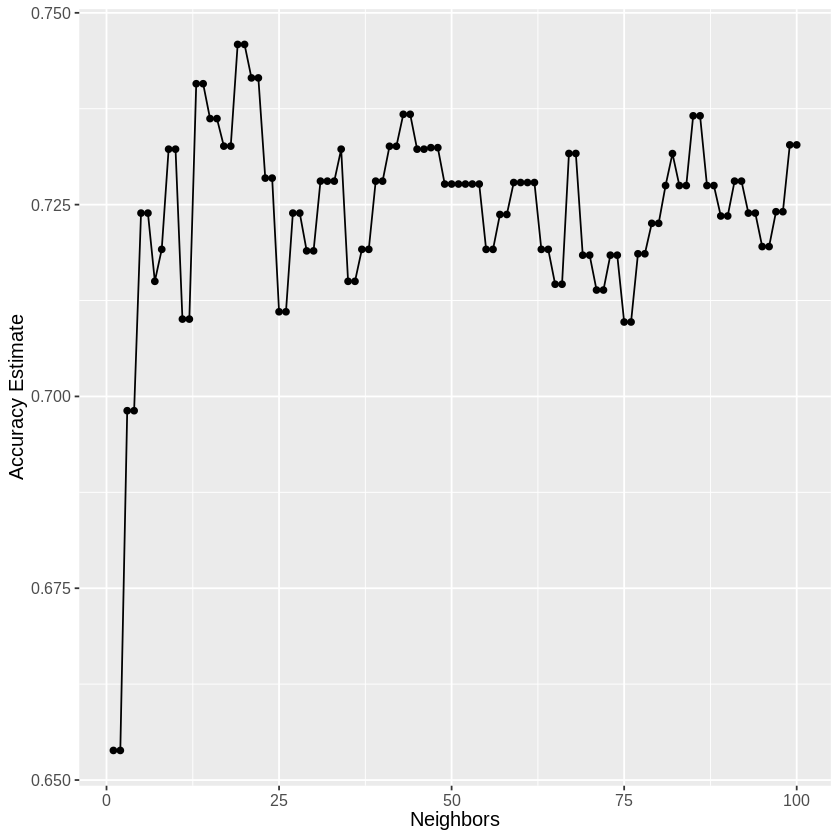

In [18]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12)) 

accuracy_vs_k

In [19]:
best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors) 

best_k

[1] 19

This is much better than the first relationship we looked at earlier! In this case where we compare the relationship between cholesterl levels and maximum heart rate, our k value of 19 gives us an accuracy of 75%! Therefore, we will pick k = 19 for our model.

## Final Model

In [23]:
set.seed(7)

final_knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("classification") 

fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(final_knn_model) |>
    fit(data = cleveland_training) 

fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2599119
Best kernel: rectangular
Best k: 19